In [135]:
import pandas as pd
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.timeseries import LombScargle
from astropy.table import Table
from scipy.signal import savgol_filter as savgol
from pathlib import Path
from scipy import ndimage, signal

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
observed_stars = pd.read_csv("observedTESSnK2.csv", index_col = 0)

In [3]:
#delta_sct = pd.DataFrame({'Name': ["Ascella", "Revati", "Porrima", "Zaniah", "kap Psc", "83 Aqr", "tet2 Tau", "ups Tau", "rho Tau", "HR 1427", "15 Ori", "97 Tau", "56 Tau", "80 Tau", "51 Tau", "89 Tau", "HR 1554", "HR 1385", "45 Cnc", "50 Cnc", "HR 5059", "49 Cnc"]})

In [4]:
delta_sct = pd.DataFrame({'Name': ["50 Cnc"]})

In [5]:
delta_sc_merged =observed_stars.merge(delta_sct, on='Name')[["Name", "EPIC ID"]]

In [6]:
delta_sc_merged

,Name,EPIC ID
0,50 Cnc,200200363


50 Cnc 200200363


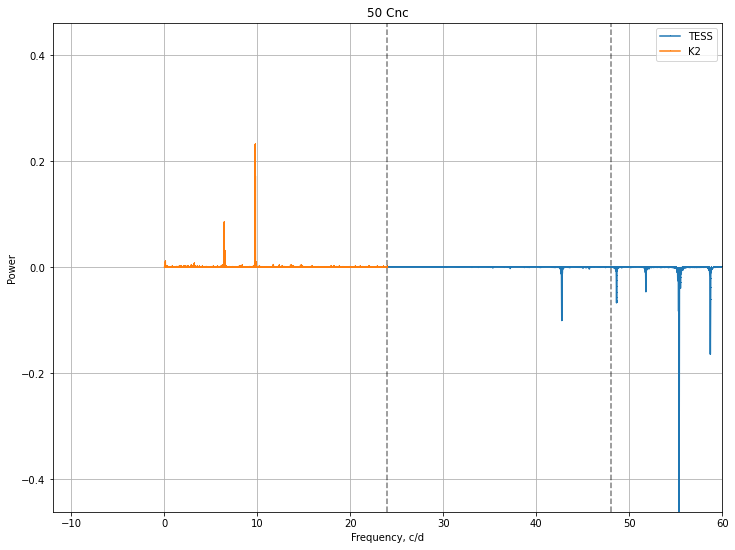

In [12]:
for index, row in delta_sc_merged.iterrows():
    print(row["Name"], row["EPIC ID"], end='')
    
    name = row["Name"]
    epic_id = row["EPIC ID"]

    #download tess
    lc_search = lk.search_lightcurve(name,exptime=120)    
    lc = lc_search.download_all()
        
    lc[0] = lc[0].remove_nans().normalize()
    tess_time = lc[0].time.value
    tess_flux = lc[0].flux.value
    min_freq_tess = 1/10.
    max_freq_tess = 360.
    freqs_tess = np.logspace(np.log10(min_freq_tess),np.log10(max_freq_tess),100000) # tess from 10 day period to 360 c/d nyquist
    ls_tess = LombScargle(tess_time, tess_flux, normalization='standard')
    power_tess = ls_tess.power(freqs_tess)
    max_freq_tess = np.round(freqs_tess[power_tess.argmax()], 3)
    
    tess_smothed_periodogram = ndimage.gaussian_filter1d(power_tess,3)
    
    tess_tpf =  lk.search_targetpixelfile(name,exptime=120).download();
    
    #download halo
    
    halo_filename = Path('/Users/uqitroit/Dev/halo_vs_tess/Tess_light_curve/fits/hlsp_halo_k2_llc_%s_lc.fits' % epic_id)
    halo = Table.read(halo_filename)
    print('')
    
    m = np.isfinite(halo['corr_flux'])
    halo = halo[m]
    halo_flux = halo['flux']
    halo_time = halo['time']
    halo_corr_flux = halo['corr_flux']
    
    halo_normalized_flux = halo_corr_flux/np.nanmedian(halo_corr_flux)
    halo_trend = savgol(halo_corr_flux/np.nanmedian(halo_corr_flux),701,3)
    
    halo_lc = LombScargle(halo_time,halo_corr_flux/np.nanmedian(halo_corr_flux)-halo_trend+np.nanmedian(halo_trend),normalization='standard') #+np.nanmedian(halo_trend)
    freqs_halo = np.linspace((1/30.),24.,100000)
    power_halo = halo_lc.power(freqs_halo)
    max_freq_halo = np.round(freqs_halo[power_halo.argmax()], 3)
    
    halo_smothed_periodogram = ndimage.gaussian_filter1d(power_halo,100)
    
    fig = plt.figure(figsize=(12.0,9.0))
    plt.plot(freqs_tess, -power_tess, '-,' ,label="TESS")
    plt.plot(freqs_halo, power_halo,'-,' , label="K2")
    plt.legend(loc="upper right", )
    ylim_set = np.max((np.max(power_tess), np.max(power_halo).value))
    #plt.axvline(1/30., alpha=0.5,linestyle='--',color='k')
    plt.axvline(24., alpha=0.5,linestyle='--',color='k') 
    plt.axvline(48., alpha=0.5,linestyle='--',color='k')
    #thruster fire harmonics
    #plt.axvline(1/30., alpha=0.5,linestyle='--',color='k')
    #plt.axvline(4.08, alpha=0.3,linestyle='-',color='r')
    #plt.axvline(8.16, alpha=0.3,linestyle='-',color='r')
    #plt.axvline(12.24, alpha=0.3,linestyle='-',color='r')
    #plt.axvline(16.32, alpha=0.3,linestyle='-',color='r')
    plt.xlim(-12., 60)
    plt.ylim(-ylim_set, ylim_set)
    plt.ylabel('Power')
    plt.xlabel('Frequency, c/d')
    plt.title('%s' %name)
    plt.grid(True)
    
    pp = PdfPages('dl_sc_freq/%s_%s.pdf' % (epic_id, name))
    pp.savefig(fig)
    pp.close()

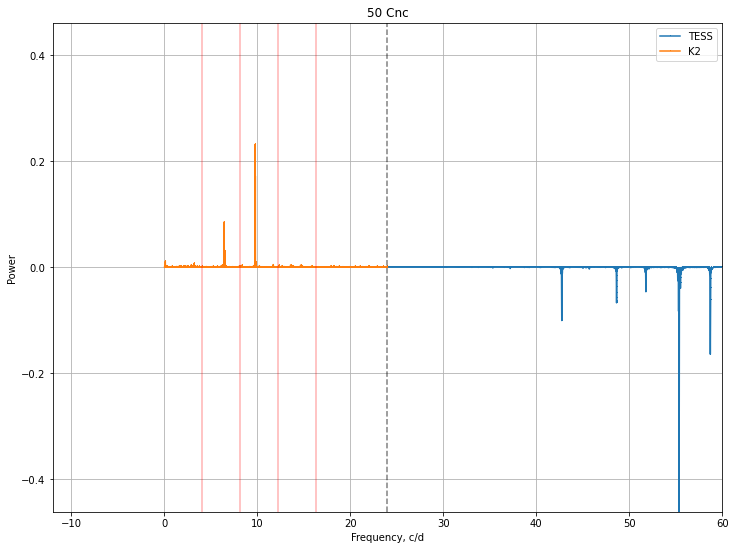

In [13]:
fig = plt.figure(figsize=(12.0,9.0))
plt.plot(freqs_tess, -power_tess, '-,' ,label="TESS")
plt.plot(freqs_halo, power_halo,'-,' , label="K2")
plt.legend(loc="upper right", )
ylim_set = np.max((np.max(power_tess), np.max(power_halo).value))
#plt.axvline(1/30., alpha=0.5,linestyle='--',color='k')
plt.axvline(24., alpha=0.5,linestyle='--',color='k') 
#thruster fire harmonics
#plt.axvline(1/30., alpha=0.5,linestyle='--',color='k')
plt.axvline(4.08, alpha=0.3,linestyle='-',color='r')
plt.axvline(8.16, alpha=0.3,linestyle='-',color='r')
plt.axvline(12.24, alpha=0.3,linestyle='-',color='r')
plt.axvline(16.32, alpha=0.3,linestyle='-',color='r')
plt.xlim(-12., 60)
plt.ylim(-ylim_set, ylim_set)
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.title('%s' %name)
plt.grid(True)


### Generate sine waves:

In [359]:
peak_ind, peak_param = signal.find_peaks(power_tess, height=0.02, width=7)
peak_val = peak_param['peak_heights']
peak_sorted = np.argsort(peak_val)[::-1][:10]

peak_sorted_ind = peak_ind[peak_sorted]
peak_sorted_freqs = freqs_tess[peak_sorted_ind]

#print(peak_val)
#print(peak_sorted)
#print(peak_val[peak_sorted])
#
#print(peak_sorted_ind)
print(peak_sorted_freqs)

[55.37172533 58.7249375  42.75071046 48.64372087 51.79691578]


In [341]:
def sine_wave(f,sampRate,phase,nCyl):
    fullTime = nCyl*1./f
    t = np.arange(0,nCyl*1./f+1./sampRate,1./sampRate) # time base
    g = np.sin(2*np.pi*f*t+phase) 
    return (t,g) # return time base and signal g(t) as tuple

In [342]:
cd_to_hz = 1/86400

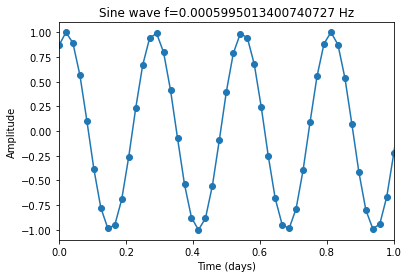

In [356]:
f = peak_sorted_freqs[4]*cd_to_hz #frequency
sampRate = 48*cd_to_hz #sampling rate
phase = 1/3*np.pi #phase shift in radians
nCyl = 1000 # number of cycles of the sine wave

(t,x) = sine_wave(f,sampRate,phase,nCyl) 

plt.plot(t*cd_to_hz,x, '-o') 
plt.title('Sine wave f='+str(f)+' Hz') 
plt.xlabel('Time (days)') 
plt.ylabel('Amplitude') 
plt.xlim(0,1)
plt.show()

In [357]:
freqs_wave = np.linspace(0,60,1000) # tess from 10 day period to 360 c/d nyquist
ls_wave = LombScargle(t*cd_to_hz, x)
power_wave = ls_wave.power(freqs_wave)

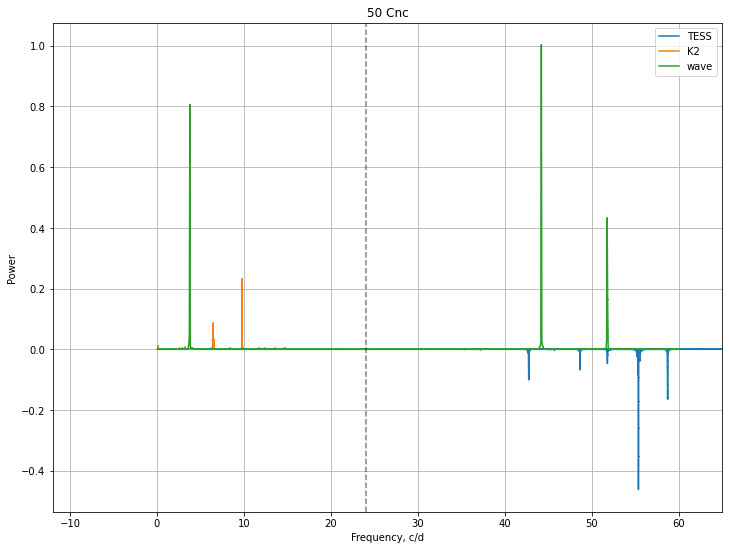

In [358]:
fig = plt.figure(figsize=(12.0,9.0))
plt.plot(freqs_tess, -power_tess, '-,' ,label="TESS")
plt.plot(freqs_halo, power_halo,'-,' , label="K2")
plt.plot(freqs_wave, power_wave,'-,',alpha=1 , label="wave")
plt.legend(loc="upper right", )
ylim_set = np.max((np.max(power_tess), np.max(power_halo).value))
#plt.axvline(1/30., alpha=0.5,linestyle='--',color='k')
plt.axvline(24., alpha=0.5,linestyle='--',color='k') 
#thruster fire harmonics
#plt.axvline(1/30., alpha=0.5,linestyle='--',color='k')
#plt.axvline(4.08, alpha=0.3,linestyle='-',color='r')
#plt.axvline(8.16, alpha=0.3,linestyle='-',color='r')
#plt.axvline(12.24, alpha=0.3,linestyle='-',color='r')
#plt.axvline(16.32, alpha=0.3,linestyle='-',color='r')
#
#plt.axvline(42, alpha=0.5,linestyle='--',color='b') 

plt.xlim(-12., 65)
#plt.ylim(-ylim_set, ylim_set)
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.title('%s' %name)
plt.grid(True)



(42.0, 60.0)

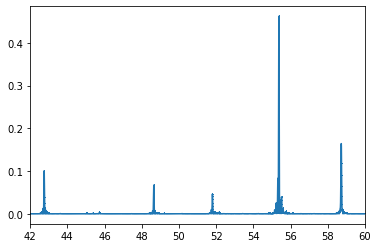

In [211]:
plt.plot(freqs_tess, power_tess, '-,' ,label="TESS")
plt.xlim(42, 60)

(73800.0, 78000.0)

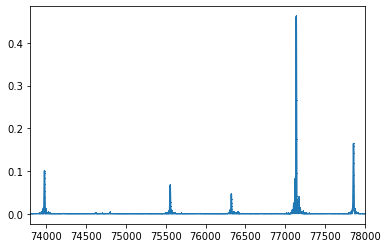

In [188]:
plt.plot(power_tess, '-,' ,label="TESS")
plt.xlim(73800,78000)